Filename identifiers

Modality (01 = full-AV, 02 = video-only, 03 = audio-only). Vocal channel (01 = speech, 02 = song). Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised). Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion. Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door"). Repetition (01 = 1st repetition, 02 = 2nd repetition). Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [1]:
import librosa 
import os
import pandas as pd
import numpy as np

import warnings

warnings.simplefilter("ignore")


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [2]:
# CREATE DIRECTORY OF AUDIO FILES 
audio = "/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/"
actor_folders = os.listdir(audio) #list files in audio directory
actor_folders.sort() 
actor_folders[0:5]

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05']

In [3]:
# EXTRACT EMOTION NUMBER, ACTOR AND GENDER LABEL
emotion = []
gender = []
actor = []
file_path = []
for i in actor_folders:
    filename = os.listdir(audio + i) #iterate over Actor folders
    for f in filename: # go through files in Actor folder
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        actor.append(int(part[6]))
        bg = int(part[6])
        if bg%2 == 0:
            bg = "female"
        else:
            bg = "male"
        gender.append(bg)
        file_path.append(audio + i + '/' + f)

In [15]:
# PUT EXTRACTED LABELS WITH FILEPATH INTO DATAFRAME
audio_df = pd.DataFrame(emotion)
audio_df = audio_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
audio_df = pd.concat([pd.DataFrame(gender),audio_df,pd.DataFrame(actor)],axis=1)
audio_df.columns = ['gender','emotion','actor']
audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)
audio_df.head()

,gender,emotion,actor,path
0,male,neutral,1,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav
1,male,neutral,1,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-02-01.wav
2,male,neutral,1,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_01/03-01-01-01-02-01-01.wav
3,male,neutral,1,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_01/03-01-01-01-02-02-01.wav
4,male,calm,1,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_01/03-01-02-01-01-01-01.wav


In [5]:
# ENSURE GENDER,EMOTION, AND ACTOR COLUMN VALUES ARE CORRECT
pd.set_option('display.max_colwidth', -1)
#Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
audio_df.sample(10)

,gender,emotion,actor,path
1334,male,happy,23,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_23/03-01-03-01-02-01-23.wav
969,male,calm,17,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_17/03-01-02-02-01-02-17.wav
462,female,fear,8,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_08/03-01-06-02-02-01-08.wav
668,female,calm,12,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_12/03-01-02-02-01-01-12.wav
950,female,disgust,16,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_16/03-01-07-02-02-01-16.wav
61,female,neutral,2,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_02/03-01-01-01-01-02-02.wav
224,female,disgust,4,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_04/03-01-07-01-01-01-04.wav
1394,female,happy,24,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_24/03-01-03-01-02-01-24.wav
1395,female,happy,24,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_24/03-01-03-01-02-02-24.wav
257,male,happy,5,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_05/03-01-03-02-01-02-05.wav


<AxesSubplot:>

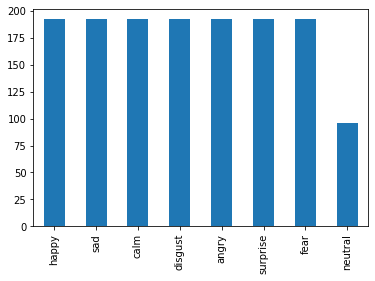

In [6]:
# LOOK AT DISTRIBUTION OF CLASSES
audio_df.emotion.value_counts().plot(kind='bar')

In [6]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT LOG MEL SPECTROGRAM MEAN VALUES INTO DF FOR MODELING 
df = pd.DataFrame(columns=['mel_spectrogram'])

counter=0

for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (transform both the y-axis (frequency) to log scale, 
    #and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
        
    df.loc[counter] = [log_spectrogram]
    counter=counter+1   


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 296
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   mel_spectrogram  297 non-null    object
dtypes: object(1)
memory usage: 4.6+ KB


In [27]:
# TURN ARRAY INTO LIST AND JOIN WITH AUDIO_DF TO GET CORRESPONDING EMOTION LABELS
df_final = pd.concat([audio_df,pd.DataFrame(df['mel_spectrogram'].values.tolist())],axis=1)
df_final = df_final.fillna(0)

In [21]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Columns: 263 entries, gender to 258
dtypes: float64(259), int64(1), object(3)
memory usage: 2.9+ MB


In [28]:
df_final.head()

,gender,emotion,actor,path,0,1,2,3,4,5,...,249,250,251,252,253,254,255,256,257,258
0,male,neutral,1,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav,-76.384773,-76.384773,-76.384773,-76.384773,-76.384773,-76.384773,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,male,neutral,1,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-02-01.wav,-75.335518,-75.445320,-75.554031,-75.203949,-75.230530,-75.319374,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,male,neutral,1,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_01/03-01-01-01-02-01-01.wav,-75.150711,-75.150711,-75.150711,-75.150711,-75.150711,-75.150711,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,male,neutral,1,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_01/03-01-01-01-02-02-01.wav,-75.268448,-75.268448,-75.268448,-75.268448,-75.268448,-75.268448,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,male,calm,1,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_01/03-01-02-01-01-01-01.wav,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,...,-80.147377,-80.147377,-80.121956,-79.998009,-80.119255,-80.147377,-80.130417,-80.014702,-80.147377,-80.147377


In [29]:
# DROP PATH COLUMN FOR MODELING
df_final.drop(columns='path',inplace=True)

## MODELING

In [31]:
# drop the target value
X = df_final.drop('emotion', axis=1)
y = df_final['emotion']


In [32]:
#encoding gender feature

X= pd.get_dummies(X)
X.head()

,actor,0,1,2,3,4,5,6,7,8,...,251,252,253,254,255,256,257,258,gender_female,gender_male
0,1,-76.384773,-76.384773,-76.384773,-76.384773,-76.384773,-76.384773,-76.384773,-76.384773,-76.384773,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1
1,1,-75.335518,-75.445320,-75.554031,-75.203949,-75.230530,-75.319374,-75.653793,-75.720039,-75.720039,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1
2,1,-75.150711,-75.150711,-75.150711,-75.150711,-75.150711,-75.150711,-75.150711,-75.139587,-75.072227,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1
3,1,-75.268448,-75.268448,-75.268448,-75.268448,-75.268448,-75.268448,-75.268448,-75.268448,-75.268448,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1
4,1,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,...,-80.121956,-79.998009,-80.119255,-80.147377,-80.130417,-80.014702,-80.147377,-80.147377,0,1


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
model = MLPClassifier(hidden_layer_sizes=(200,), learning_rate='adaptive', max_iter=400)

In [35]:
model.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(200,), learning_rate='adaptive', max_iter=400)

In [36]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy of the Recognizer is: {:.1f}%".format(accuracy*100))

Accuracy of the Recognizer is: 27.1%


sélectionner d'autres features